In [4]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder("Split_Data/train", transform=transform)
val_data = datasets.ImageFolder("Split_Data/val", transform=transform)
test_data = datasets.ImageFolder("Split_Data/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [5]:
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze base layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/diptidhawade/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 24.9MB/s]


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Try more epochs for better performance
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 2.6624794006347656
Epoch 2, Loss: 2.5447001854578652
Epoch 3, Loss: 2.2672539353370667
Epoch 4, Loss: 2.0542931159337363
Epoch 5, Loss: 2.0143991708755493
Epoch 6, Loss: 1.821606437365214
Epoch 7, Loss: 1.7721197605133057
Epoch 8, Loss: 1.767492264509201
Epoch 9, Loss: 1.725175529718399
Epoch 10, Loss: 1.7011344234148662


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 34.75%


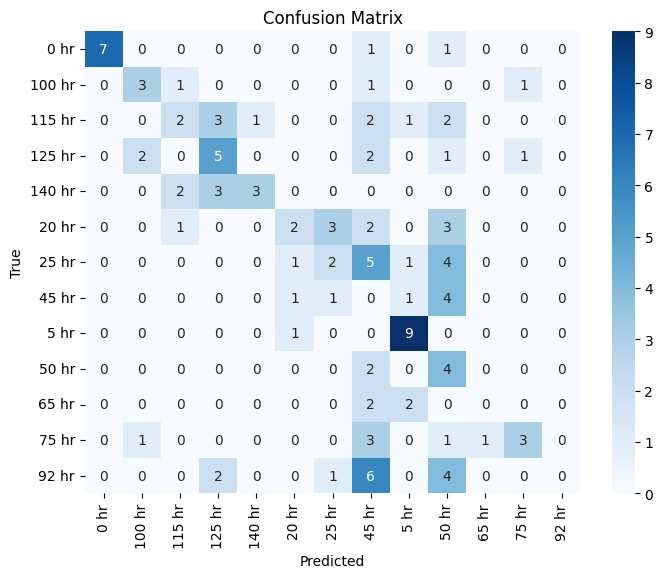

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set and store predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = train_data.classes  # This assumes train_data has all classes

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Step 1: Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 2: Custom folder-to-label mapping
def load_custom_dataset(root_dir):
    image_paths = []
    labels = []
    class_names = []
    label_map = {}

    for time_folder in os.listdir(root_dir):
        time_path = os.path.join(root_dir, time_folder)
        if not os.path.isdir(time_path): continue

        for ph_folder in os.listdir(time_path):
            class_label = f"{time_folder.replace(' ', '')}_{ph_folder.replace(' ', '_')}"
            if class_label not in label_map:
                label_map[class_label] = len(label_map)
                class_names.append(class_label)

            ph_path = os.path.join(time_path, ph_folder)
            for img in os.listdir(ph_path):
                img_path = os.path.join(ph_path, img)
                image_paths.append(img_path)
                labels.append(label_map[class_label])

    return image_paths, labels, class_names


In [10]:
from PIL import Image
from torch.utils.data import Dataset

class HydrogelDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

    def __len__(self):
        return len(self.image_paths)


In [11]:
# Load data
train_paths, train_labels, class_names = load_custom_dataset("Split_Data/train")
val_paths, val_labels, _ = load_custom_dataset("Split_Data/val")
test_paths, test_labels, _ = load_custom_dataset("Split_Data/test")

# Create datasets
train_dataset = HydrogelDataset(train_paths, train_labels, transform)
val_dataset = HydrogelDataset(val_paths, val_labels, transform)
test_dataset = HydrogelDataset(test_paths, test_labels, transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Freeze base layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation
        validate(model, val_loader)

def validate(model, val_loader):
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    print(f"Val Loss: {val_loss / len(val_loader.dataset):.4f}, Val Accuracy: {correct / len(val_loader.dataset):.4f}")


In [14]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Train Loss: 5.7638, Accuracy: 0.0056
Val Loss: 5.3669, Val Accuracy: 0.0085


Epoch 2/10: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Train Loss: 4.2027, Accuracy: 0.0876
Val Loss: 4.7982, Val Accuracy: 0.0424


Epoch 3/10: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Train Loss: 3.4546, Accuracy: 0.2090
Val Loss: 4.9146, Val Accuracy: 0.0169


Epoch 4/10: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Train Loss: 2.8854, Accuracy: 0.3475
Val Loss: 5.1042, Val Accuracy: 0.0169


Epoch 5/10: 100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Train Loss: 2.3132, Accuracy: 0.5056
Val Loss: 5.2441, Val Accuracy: 0.0000


Epoch 6/10: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Train Loss: 1.9714, Accuracy: 0.6017
Val Loss: 5.4092, Val Accuracy: 0.0169


Epoch 7/10: 100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Train Loss: 1.6251, Accuracy: 0.6921
Val Loss: 5.5976, Val Accuracy: 0.0085


Epoch 8/10: 100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Train Loss: 1.3400, Accuracy: 0.7571
Val Loss: 5.6005, Val Accuracy: 0.0254


Epoch 9/10: 100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Train Loss: 1.1637, Accuracy: 0.8051
Val Loss: 5.7817, Val Accuracy: 0.0254


Epoch 10/10: 100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Train Loss: 0.9772, Accuracy: 0.8362
Val Loss: 5.9243, Val Accuracy: 0.0339


In [17]:
def test_accuracy(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = outputs.argmax(1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f} ({correct}/{total})")

In [18]:
test_accuracy(model, test_loader)

Test Accuracy: 0.0424 (5/118)


In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
def get_predictions(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
    return y_true, y_pred

# Plot confusion matrix
def plot_confusion_matrix(model, test_loader, class_names):
    y_true, y_pred = get_predictions(model, test_loader)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(xticks_rotation=45, ax=ax, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()


In [21]:
#plot_confusion_matrix(model, test_loader, class_names)

In [22]:
import os
import shutil
from pathlib import Path

# Paths
source_root = Path("Split_Data")
target_root = Path("Split_Data_Reorg")

# Folders to process
splits = ['train', 'val', 'test']

# Create new base folders
for split in splits:
    (target_root / split).mkdir(parents=True, exist_ok=True)

# Loop through each split directory
for split in splits:
    split_path = source_root / split

    # Traverse time folders (e.g., 0 hr, 5 hr, etc.)
    for time_folder in split_path.iterdir():
        if not time_folder.is_dir():
            continue

        for condition_folder in time_folder.iterdir():
            if not condition_folder.is_dir():
                continue

            # Create destination folder like: Split_Data_Reorg/train/pH5 Enzymatic
            dest_folder = target_root / split / condition_folder.name
            dest_folder.mkdir(parents=True, exist_ok=True)

            # Move/copy each file from original to new structure
            for image_file in condition_folder.glob("*"):
                if image_file.is_file():
                    shutil.copy(image_file, dest_folder / image_file.name)

print("✅ Folder structure reorganized successfully!")

✅ Folder structure reorganized successfully!


In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_dir = "Split_Data_Reorg"
batch_size = 16
image_size = 224

# Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Datasets and Loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
               for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # New output layer
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Save best model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

# Load best weights
model.load_state_dict(best_model_wts)
print("\n✅ Training complete.")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
train Loss: 1.9852 Acc: 0.2914
val Loss: 1.8975 Acc: 0.3983

Epoch 2/10
train Loss: 1.5932 Acc: 0.4000
val Loss: 1.5060 Acc: 0.5169

Epoch 3/10
train Loss: 1.3148 Acc: 0.5800
val Loss: 1.4888 Acc: 0.5678

Epoch 4/10
train Loss: 1.1721 Acc: 0.6343
val Loss: 1.3856 Acc: 0.4915

Epoch 5/10
train Loss: 1.1225 Acc: 0.6286
val Loss: 1.2621 Acc: 0.5847

Epoch 6/10
train Loss: 0.9640 Acc: 0.7029
val Loss: 1.0915 Acc: 0.6441

Epoch 7/10
train Loss: 0.9609 Acc: 0.6657
val Loss: 1.0743 Acc: 0.6695

Epoch 8/10
train Loss: 0.8398 Acc: 0.7629
val Loss: 0.9750 Acc: 0.7119

Epoch 9/10
train Loss: 0.8054 Acc: 0.7714
val Loss: 1.0134 Acc: 0.6695

Epoch 10/10
train Loss: 0.7962 Acc: 0.7600
val Loss: 1.1055 Acc: 0.5678

✅ Training complete.



🎯 Test Accuracy: 0.4831


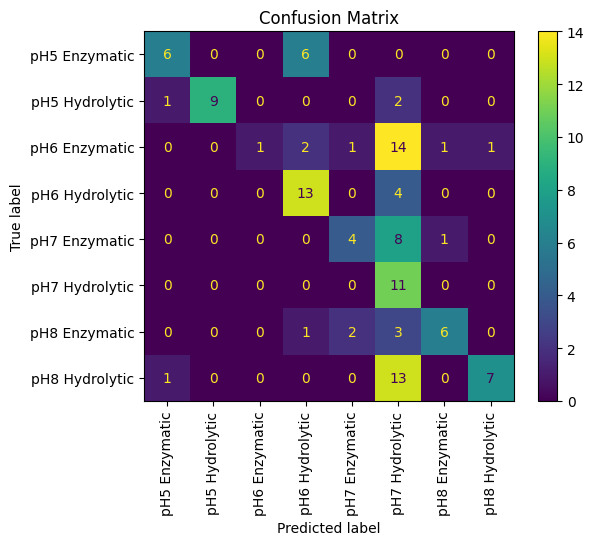


Classification Report:
                precision    recall  f1-score   support

 pH5 Enzymatic       0.75      0.50      0.60        12
pH5 Hydrolytic       1.00      0.75      0.86        12
 pH6 Enzymatic       1.00      0.05      0.10        20
pH6 Hydrolytic       0.59      0.76      0.67        17
 pH7 Enzymatic       0.57      0.31      0.40        13
pH7 Hydrolytic       0.20      1.00      0.33        11
 pH8 Enzymatic       0.75      0.50      0.60        12
pH8 Hydrolytic       0.88      0.33      0.48        21

      accuracy                           0.48       118
     macro avg       0.72      0.53      0.50       118
  weighted avg       0.75      0.48      0.48       118



In [26]:
from sklearn.metrics import classification_report

# Evaluate test accuracy
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Accuracy
test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n🎯 Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

# Optional: Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))